# VampNet Step-by-Step for ONNX Export

This notebook breaks down the VampNet process into individual PyTorch modules that can be exported to ONNX via TorchScript.

The VampNet pipeline consists of:
1. Audio preprocessing
2. Codec encoding (audio → tokens)
3. Mask generation
4. Transformer inference (masked tokens → new tokens)
5. Codec decoding (tokens → audio)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import audiotools as at
import vampnet
import IPython.display as ipd
import matplotlib.pyplot as plt
from typing import Tuple, Optional
import sys
import os

# Add parent directory to path to import our modules
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('./'))))

# Import our ONNX-compatible modules
from vampnet_onnx.vampnet_codec import VampNetCodecEncoder, VampNetCodecDecoder
from vampnet_onnx.audio_processor import AudioProcessor
from vampnet_onnx.exporters import export_codec_encoder, export_codec_decoder

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

/Users/stephen/Documents/Development/MusicHackspace/vampnet-onnx-export/venv/lib/python3.11/site-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


Using device: cpu


## 1. Load VampNet Models

In [2]:
# Load the interface with local models to avoid downloading
interface = vampnet.interface.Interface(
    codec_ckpt="../models/vampnet/codec.pth",
    coarse_ckpt="../models/vampnet/coarse.pth",
    coarse2fine_ckpt="../models/vampnet/c2f.pth",
    wavebeat_ckpt="../models/vampnet/wavebeat.pth"
)
interface.to(device)

# Extract the actual models
codec_model = interface.codec
coarse_model = interface.coarse
c2f_model = interface.c2f if hasattr(interface, 'c2f') else None

print(f"Codec sample rate: {codec_model.sample_rate}")
print(f"Codec hop length: {codec_model.hop_length}")
print(f"Codec n_codebooks: {codec_model.n_codebooks}")
print(f"Coarse model codebooks: {coarse_model.n_codebooks}")
if c2f_model:
    print(f"C2F model codebooks: {c2f_model.n_codebooks}")

/Users/stephen/Documents/Development/MusicHackspace/vampnet-onnx-export/venv/lib/python3.11/site-packages/audiotools/ml/layers/base.py:173: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimenta

Codec sample rate: 44100
Codec hop length: 768
Codec n_codebooks: 14
Coarse model codebooks: 4
C2F model codebooks: 14


## 2. Audio Preprocessing Module

In [3]:
# Use our improved AudioProcessor
audio_processor = AudioProcessor(
    target_sample_rate=codec_model.sample_rate,
    target_loudness=-24.0,
    hop_length=codec_model.hop_length
)

# Test the preprocessor
test_audio = torch.randn(1, 2, 44100)  # 1 second stereo at 44.1kHz
preprocessed = audio_processor(test_audio)
print(f"Preprocessed shape: {preprocessed.shape}")
print(f"Preprocessed RMS: {torch.sqrt(torch.mean(preprocessed**2)).item():.6f}")
print(f"Preprocessed max: {torch.max(torch.abs(preprocessed)).item():.6f}")

Preprocessed shape: torch.Size([1, 1, 44544])
Preprocessed RMS: 0.062780
Preprocessed max: 0.276289


## 3. Codec Wrapper Modules

In [4]:
# Use our VampNetCodec wrappers
encoder = VampNetCodecEncoder(codec_model, device=device)
decoder = VampNetCodecDecoder(codec_model, device=device)

# Test with real audio
test_signal = at.AudioSignal("../assets/example.wav")
test_audio = interface._preprocess(test_signal).samples.to(device)
print(f"Test audio shape: {test_audio.shape}")

# Encode and decode
codes = encoder(test_audio)
print(f"Encoded codes shape: {codes.shape}")
print(f"Codes dtype: {codes.dtype}")
print(f"Codes range: [{codes.min().item()}, {codes.max().item()}]")

# Now decoding should work with our fixed decoder
decoded = decoder(codes)
print(f"Decoded audio shape: {decoded.shape}")

# Test reconstruction quality
mse = torch.mean((test_audio - decoded[:, :, :test_audio.shape[-1]]) ** 2)
snr = 10 * torch.log10(torch.mean(test_audio ** 2) / (mse + 1e-8))
print(f"Reconstruction SNR: {snr.item():.2f} dB")

Test audio shape: torch.Size([1, 1, 662016])
Encoded codes shape: torch.Size([1, 14, 862])
Codes dtype: torch.int64
Codes range: [0, 1023]
Decoded audio shape: torch.Size([1, 1, 662016])
Reconstruction SNR: 10.12 dB


## 4. Mask Generation Module

Mask shape: torch.Size([1, 14, 862])
Mask density: 0.969
Masked codes shape: torch.Size([1, 14, 862])
Number of mask tokens: 11696


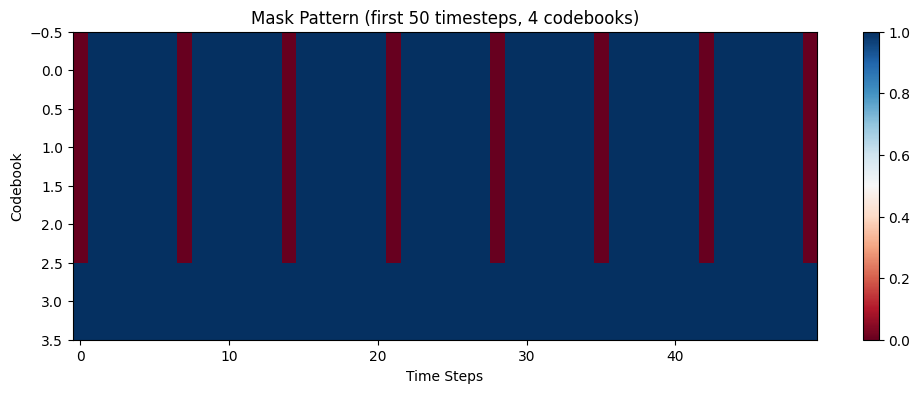

In [5]:
class MaskGenerator(nn.Module):
    """Generates masks for VampNet token generation"""
    
    def __init__(self, n_codebooks: int = 14, mask_token: int = 1024):
        super().__init__()
        self.n_codebooks = n_codebooks
        self.mask_token = mask_token
        
    def forward(self, 
                codes: torch.Tensor,
                periodic_prompt: int = 7,
                upper_codebook_mask: int = 3) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Args:
            codes: Input tokens [batch, n_codebooks, sequence_length]
            periodic_prompt: Keep every Nth token
            upper_codebook_mask: Number of lower codebooks to apply masking to
        Returns:
            mask: Binary mask [batch, n_codebooks, sequence_length]
            masked_codes: Codes with mask tokens applied
        """
        batch_size, n_codebooks, seq_len = codes.shape
        
        # Create periodic mask
        mask = torch.ones_like(codes, dtype=torch.long)
        
        # Apply periodic pattern (keep every Nth token)
        for i in range(0, seq_len, periodic_prompt):
            mask[:, :, i] = 0
        
        # Apply codebook masking
        if upper_codebook_mask > 0:
            # Keep the pattern only for lower codebooks
            mask[:, upper_codebook_mask:, :] = 1
        
        # Apply mask to codes
        masked_codes = codes.clone()
        masked_codes[mask.bool()] = self.mask_token
        
        return mask, masked_codes


# Test mask generator
mask_gen = MaskGenerator(n_codebooks=14, mask_token=1024)
mask, masked_codes = mask_gen(codes, periodic_prompt=7, upper_codebook_mask=3)

print(f"Mask shape: {mask.shape}")
print(f"Mask density: {mask.float().mean():.3f}")
print(f"Masked codes shape: {masked_codes.shape}")
print(f"Number of mask tokens: {(masked_codes == 1024).sum().item()}")

# Visualize mask
plt.figure(figsize=(12, 4))
plt.imshow(mask[0, :4, :50].cpu().numpy(), aspect='auto', cmap='RdBu')
plt.title('Mask Pattern (first 50 timesteps, 4 codebooks)')
plt.xlabel('Time Steps')
plt.ylabel('Codebook')
plt.colorbar()
plt.show()

## 5. Transformer Inference Module

In [6]:
class VampNetInference(nn.Module):
    """Wraps VampNet transformer for ONNX-compatible inference"""
    
    def __init__(self, coarse_model, c2f_model=None):
        super().__init__()
        self.coarse = coarse_model
        self.c2f = c2f_model
        self.n_coarse_codebooks = coarse_model.n_codebooks
        
    def forward(self, 
                masked_codes: torch.Tensor,
                mask: torch.Tensor,
                temperature: float = 1.0) -> torch.Tensor:
        """
        Args:
            masked_codes: Codes with mask tokens [batch, n_codebooks, seq_len]
            mask: Binary mask [batch, n_codebooks, seq_len]
            temperature: Sampling temperature
        Returns:
            Generated tokens [batch, n_codebooks, seq_len]
        """
        # Extract coarse codes and mask
        coarse_codes = masked_codes[:, :self.n_coarse_codebooks, :]
        coarse_mask = mask[:, :self.n_coarse_codebooks, :]
        
        # Run coarse generation
        # Note: For ONNX export, we'll need a simplified version without sampling
        with torch.no_grad():
            # Get model output (logits)
            if hasattr(self.coarse, '_orig_mod'):
                model = self.coarse._orig_mod
            else:
                model = self.coarse
                
            # Forward pass through transformer
            logits = model(coarse_codes)
            
            # Apply temperature
            logits = logits / temperature
            
            # Get predictions (argmax for deterministic)
            predictions = torch.argmax(logits, dim=-1)
            
            # Only update masked positions
            generated_coarse = coarse_codes.clone()
            generated_coarse[coarse_mask.bool()] = predictions[coarse_mask.bool()]
        
        # Run coarse-to-fine if available
        if self.c2f is not None:
            with torch.no_grad():
                # C2F generates all codebooks from coarse
                fine_codes = self.c2f.generate(
                    codec=interface.codec,
                    time_steps=generated_coarse.shape[-1],
                    coarse_codes=generated_coarse,
                    device=generated_coarse.device
                )
                return fine_codes
        else:
            # Return coarse codes with original fine codes
            return torch.cat([
                generated_coarse,
                masked_codes[:, self.n_coarse_codebooks:, :]
            ], dim=1)


# Note: For actual ONNX export, we'll need a simpler version
# that doesn't use the complex sampling logic

## 6. Simplified Models for ONNX Export

In [7]:
# Export the actual VampNet codec to ONNX
output_dir = "../onnx_models/vampnet_codec"
os.makedirs(output_dir, exist_ok=True)

# Export encoder
print("Exporting VampNet codec encoder...")
export_codec_encoder(
    output_path=os.path.join(output_dir, "encoder.onnx"),
    n_codebooks=codec_model.n_codebooks,
    vocab_size=1024,
    sample_rate=codec_model.sample_rate,
    hop_length=codec_model.hop_length,
    example_batch_size=1,
    example_audio_length=codec_model.sample_rate * 2,  # 2 seconds
    use_simplified=False,
    use_vampnet=True,
    codec_model=codec_model,
    device=device,
    opset_version=14
)

# Export decoder
print("\nExporting VampNet codec decoder...")
export_codec_decoder(
    output_path=os.path.join(output_dir, "decoder.onnx"),
    n_codebooks=codec_model.n_codebooks,
    vocab_size=1024,
    sample_rate=codec_model.sample_rate,
    hop_length=codec_model.hop_length,
    example_batch_size=1,
    example_sequence_length=100,
    use_simplified=False,
    use_vampnet=True,
    codec_model=codec_model,
    device=device,
    opset_version=14
)

print(f"\nExported codec models to {output_dir}")

Exporting VampNet codec encoder...
Using VampNet codec encoder...


/Users/stephen/Documents/Development/MusicHackspace/vampnet-onnx-export/vampnet_onnx/vampnet_codec.py:68: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if right_pad > 0:
/Users/stephen/Documents/Development/MusicHackspace/vampnet-onnx-export/venv/lib/python3.11/site-packages/lac/model/lac.py:259: TracerWarning: Converting a tensor to a Python float might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  right_pad = math.ceil(length / self.hop_length) * self.hop_length - length


Exported codec encoder to ../onnx_models/vampnet_codec/encoder.onnx
Model verification passed!

Exporting VampNet codec decoder...
Using VampNet codec decoder...
Exported codec decoder to ../onnx_models/vampnet_codec/decoder.onnx
Model verification passed!

Exported codec models to ../onnx_models/vampnet_codec


In [8]:
class SimplifiedVampNetForONNX(nn.Module):
    """Simplified VampNet model suitable for ONNX export"""
    
    def __init__(self, coarse_model):
        super().__init__()
        # Extract the actual model if it's wrapped
        if hasattr(coarse_model, '_orig_mod'):
            self.model = coarse_model._orig_mod
        else:
            self.model = coarse_model
            
        self.n_codebooks = self.model.n_codebooks
        self.mask_token = self.model.mask_token
        
    def forward(self, masked_codes: torch.Tensor) -> torch.Tensor:
        """
        Simplified forward pass for ONNX export.
        
        Args:
            masked_codes: Input codes with mask tokens [batch, n_codebooks, seq_len]
        Returns:
            Logits for each position [batch, n_codebooks, seq_len, vocab_size]
        """
        # Get logits from the model
        logits = self.model(masked_codes)
        return logits


class SimplifiedMaskingForONNX(nn.Module):
    """Simplified masking suitable for ONNX export"""
    
    def __init__(self, mask_token: int = 1024):
        super().__init__()
        self.mask_token = mask_token
        
    def forward(self, 
                codes: torch.Tensor,
                mask: torch.Tensor) -> torch.Tensor:
        """
        Apply mask to codes.
        
        Args:
            codes: Input tokens [batch, n_codebooks, seq_len]
            mask: Binary mask (1=mask, 0=keep) [batch, n_codebooks, seq_len]
        Returns:
            Masked codes
        """
        # Create masked codes
        masked_codes = codes.clone()
        masked_codes = torch.where(
            mask.bool(),
            torch.full_like(codes, self.mask_token),
            codes
        )
        return masked_codes

## 7. ONNX Export Examples

In [9]:
# Export the masking module
masking_module = SimplifiedMaskingForONNX(mask_token=1024)
masking_module.eval()

# Example inputs
example_codes = torch.randint(0, 1024, (1, 4, 100))
example_mask = torch.randint(0, 2, (1, 4, 100))

# Export to ONNX with opset version 14
torch.onnx.export(
    masking_module,
    (example_codes, example_mask),
    "vampnet_masking.onnx",
    input_names=['codes', 'mask'],
    output_names=['masked_codes'],
    dynamic_axes={
        'codes': {0: 'batch', 2: 'sequence'},
        'mask': {0: 'batch', 2: 'sequence'},
        'masked_codes': {0: 'batch', 2: 'sequence'}
    },
    opset_version=14  # Updated to 14
)

print("Exported masking module to vampnet_masking.onnx")

Exported masking module to vampnet_masking.onnx


In [10]:
# Export a simplified transformer (without the full VampNet model)
# Note: The full VampNet model is very large and complex for ONNX export

# For demonstration, let's create a minimal transformer block
class MinimalTransformerBlock(nn.Module):
    def __init__(self, d_model=512, n_heads=8, vocab_size=1024):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size + 1, d_model)  # +1 for mask token
        self.transformer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=2048,
            batch_first=True
        )
        self.output_proj = nn.Linear(d_model, vocab_size)
        
    def forward(self, tokens):
        # tokens: [batch, n_codebooks, seq_len]
        batch, n_codebooks, seq_len = tokens.shape
        
        # Flatten codebooks
        tokens_flat = tokens.view(batch, -1)  # [batch, n_codebooks * seq_len]
        
        # Embed
        x = self.embedding(tokens_flat)  # [batch, n_codebooks * seq_len, d_model]
        
        # Transform
        x = self.transformer(x)
        
        # Project to vocabulary
        logits = self.output_proj(x)  # [batch, n_codebooks * seq_len, vocab_size]
        
        # Reshape back
        logits = logits.view(batch, n_codebooks, seq_len, -1)
        
        return logits


# Create and export minimal transformer
minimal_transformer = MinimalTransformerBlock()
minimal_transformer.eval()

example_tokens = torch.randint(0, 1024, (1, 4, 50))

torch.onnx.export(
    minimal_transformer,
    example_tokens,
    "minimal_transformer.onnx",
    input_names=['tokens'],
    output_names=['logits'],
    dynamic_axes={
        'tokens': {0: 'batch', 2: 'sequence'},
        'logits': {0: 'batch', 2: 'sequence'}
    },
    opset_version=14  # Updated to 14
)

print("Exported minimal transformer to minimal_transformer.onnx")

Exported minimal transformer to minimal_transformer.onnx


## 8. Complete Pipeline Example

In [11]:
class VampNetPipeline:
    """Complete VampNet pipeline using individual modules"""
    
    def __init__(self, interface):
        self.interface = interface
        self.device = next(interface.coarse.parameters()).device
        
    def process_audio(self, audio_path: str, 
                     periodic_prompt: int = 7,
                     upper_codebook_mask: int = 3,
                     temperature: float = 1.0):
        """
        Process audio through the complete VampNet pipeline.
        """
        # Step 1: Load and preprocess audio
        signal = at.AudioSignal(audio_path)
        preprocessed = self.interface._preprocess(signal)
        
        # Step 2: Encode to tokens
        codes = self.interface.encode(preprocessed)
        print(f"Encoded shape: {codes.shape}")
        
        # Step 3: Generate mask
        mask = self.interface.build_mask(
            codes, preprocessed,
            periodic_prompt=periodic_prompt,
            upper_codebook_mask=upper_codebook_mask
        )
        print(f"Mask density: {mask.float().mean():.3f}")
        
        # Step 4: Generate new tokens
        generated = self.interface.vamp(
            codes, mask,
            temperature=temperature,
            return_mask=False
        )
        
        # Step 5: Decode to audio
        output = self.interface.decode(generated)
        
        return {
            'original': preprocessed,
            'codes': codes,
            'mask': mask,
            'generated': generated,
            'output': output
        }


# Run the complete pipeline
pipeline = VampNetPipeline(interface)
results = pipeline.process_audio(
    "../assets/example.wav",
    periodic_prompt=7,
    upper_codebook_mask=3
)

# Save output
results['output'].write("vampnet_pipeline_output.wav")
print("\nSaved output to vampnet_pipeline_output.wav")

# Display
print("\nOriginal audio:")
ipd.display(ipd.Audio(results['original'].samples.squeeze().cpu().numpy(), 
                     rate=results['original'].sample_rate))

print("\nGenerated audio:")
ipd.display(ipd.Audio(results['output'].samples.squeeze().cpu().numpy(), 
                     rate=results['output'].sample_rate))

Encoded shape: torch.Size([1, 14, 862])
Mask density: 0.969


/Users/stephen/Documents/Development/MusicHackspace/vampnet-onnx-export/venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:265: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(



Saved output to vampnet_pipeline_output.wav

Original audio:



Generated audio:


## 9. Notes on ONNX Export

### Challenges and Solutions:

1. **Model Size**: The full VampNet models are very large (300M+ parameters). Consider:
   - Exporting only the inference path (no training ops)
   - Quantization to reduce model size
   - Splitting into separate ONNX models (encoder, transformer, decoder)

2. **Dynamic Shapes**: Audio can have variable length. Use dynamic axes in ONNX export.

3. **Sampling Operations**: The stochastic sampling in VampNet needs modification for ONNX:
   - Use deterministic argmax instead of sampling
   - Or implement sampling as a separate post-processing step

4. **Complex Operations**: Some VampNet operations may need simplification:
   - Replace complex attention mechanisms with standard ops
   - Simplify the iterative decoding process

### Recommended Export Strategy:

1. Export individual components separately:
   - `vampnet_encoder.onnx`: Audio → Tokens
   - `vampnet_masking.onnx`: Token masking
   - `vampnet_transformer.onnx`: Masked tokens → Generated tokens
   - `vampnet_decoder.onnx`: Tokens → Audio

2. Use TorchScript as an intermediate step:
   ```python
   scripted_model = torch.jit.script(model)
   torch.onnx.export(scripted_model, ...)
   ```

3. Validate exported models:
   ```python
   import onnx
   import onnxruntime
   
   # Check model
   onnx_model = onnx.load("model.onnx")
   onnx.checker.check_model(onnx_model)
   
   # Test inference
   ort_session = onnxruntime.InferenceSession("model.onnx")
   ```